# Trabalho FIA - Raciocinio Espacial Neuro-Simbolico com LTNtorch



# 1. NeSy (Neuro-Symbolic) e Logic Tensor Networks (LTN)

## O que é NeSy?

**Neuro-Symbolic (NeSy)** é uma linha de pesquisa que busca combinar duas abordagens tradicionais de IA:

- **Simbólica (lógica/regras):** representa conhecimento explicitamente (ex.: regras, restrições, ontologias), o que facilita **interpretação**, **composição de conhecimento** e **raciocínio**.

- **Neural (redes neurais):** aprende padrões a partir de dados, sendo robusta a ruído e com boa capacidade de generalização, porém costuma ser menos interpretável.

Em problemas do mundo real, frequentemente temos **dados imperfeitos** (onde redes ajudam) e **conhecimento prévio** (regras/estruturas) que gostaríamos de impor (onde lógica ajuda). NeSy tenta aproveitar o melhor dos dois mundos: **aprender com dados** e **respeitar conhecimento lógico**.

---

## O que são Logic Tensor Networks (LTN)?

**Logic Tensor Networks (LTN)** são um arcabouço NeSy que representa **predicados lógicos** por meio de **funções diferenciáveis** (geralmente redes neurais) e traduz fórmulas da lógica (com conectivos e quantificadores) para operações numéricas contínuas no intervalo [0,1].

### Ideia central

Cada **predicado** (ex.: `leftOf(x,y)`, `isSquare(x)`) é implementado como um modelo neural que retorna um grau de verdade:

$$P(\cdot) \in [0,1]$$

Conectivos lógicos são implementados via **lógica fuzzy** (t-norms e implicações suaves), por exemplo:

- **Conjunção (AND):** aproximação diferenciável de $a \land b$
- **Disjunção (OR):** aproximação diferenciável de $a \lor b$
- **Negação (NOT):** aproximação diferenciável de $\lnot a$
- **Implicação:** aproximação diferenciável de $a \Rightarrow b$

Quantificadores também são "suavizados", agregando valores sobre um domínio finito:

- **Existencial:** $\exists x\, \varphi(x)$ ≈ `max` (ou outra agregação) sobre $x$
- **Universal:** $\forall x\, \varphi(x)$ ≈ `mean/min` (ou outra agregação) sobre $x$

### Aprendizado por satisfação de fórmulas

Ao invés de treinar apenas com rótulos clássicos, o LTN pode treinar para **maximizar a satisfação** de um conjunto de axiomas/regras:

$$\max \text{ SatAgg}(\mathcal{K})$$

onde $\mathcal{K}$ é a base de conhecimento (KB) com as fórmulas do problema, e `SatAgg` é uma agregação das satisfações das fórmulas.

---

## Vantagens do LTN

- **Integração de conhecimento prévio:** incorpora regras e restrições diretamente no processo de aprendizado
- **Interpretabilidade:** as fórmulas lógicas tornam o modelo mais transparente
- **Aprendizado com poucos dados:** o conhecimento prévio pode compensar a escassez de dados rotulados
- **Consistência lógica:** garante que as predições respeitem as regras especificadas

---

## Por que isso é útil neste trabalho?
Neste trabalho, usamos LTN para aprender predicados neurais (por exemplo, relações espaciais) enquanto impomos **restrições lógicas** (ex.: irreflexividade, assimetria, transitividade, inversos). Assim, o modelo aprende padrões nos dados, mas também é guiado por regras, produzindo uma solução mais **consistente**.

# 2. Dataset CLEVR simplificado (vetor 11D)

Cada objeto é representado por um vetor de tamanho **11**:

- **[0, 1]**: posição *(x, y)* em coordenadas normalizadas (0.0 a 1.0)  
- **[2, 3, 4]**: cor one-hot *(vermelho, verde, azul)*  
- **[5, 6, 7, 8, 9]**: forma one-hot *(círculo, quadrado, cilindro, cone, triângulo)*  
- **[10]**: tamanho *(pequeno=0.0, grande=1.0)*

A cena possui **25 objetos** (como no enunciado).


# 3. Implementação (LTNtorch)

Nesta seção ficam os blocos de código principais: setup, geração do dataset (25 objetos), definição dos predicados (redes neurais), axiomas (KB) e o treino.


## 3.1 Setup e constantes


In [ ]:
import sys, importlib.metadata as md

# Remove o pacote errado (se alguém tiver instalado antes)
!pip -q uninstall -y ltn || true

# Instala a versão correta do LTNtorch (trava a versão)
!pip -q install "LTNtorch==1.0.2"

# Se 'ltn' já foi importado antes, precisa reiniciar o runtime
if "ltn" in sys.modules:
    raise RuntimeError(
        "O módulo 'ltn' já estava carregado neste runtime.\n"
        "No Colab: Ambiente de execução → Reiniciar Sessão, depois execute esta célula novamente."
    )

import ltn
print("LTNtorch =", md.version("LTNtorch"))
print("ltn carregado de:", ltn.__file__)
print("tem Connective?", hasattr(ltn, "Connective"))

if not hasattr(ltn, "Connective"):
    raise RuntimeError(
        "Você não está usando o 'ltn' do LTNtorch compatível com este notebook.\n"
        "Tente: Ambiente de execução → Reiniciar Sessão, depois execute esta célula novamente."
    )

In [ ]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import display, Markdown

torch.set_default_dtype(torch.float32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)
print("PyTorch:", torch.__version__)


Usando device: cuda:0
PyTorch: 2.9.0+cu126


In [3]:
# Constantes do domínio

COLORS = ["vermelho", "verde", "azul"]
SHAPES = ["circulo", "quadrado", "cilindro", "cone", "triangulo"]

IDX = {
    "pos_x": 0,
    "pos_y": 1,
    "colors": slice(2, 5),
    "shapes": slice(5, 10),
    "size": 10,
}


In [4]:
# Conectivos e agregadores (LTNtorch - API com ltn.Connective / ltn.Quantifier)

Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())

# Quantificadores (pMeanError para ∀ e pMean para ∃)
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")

# Agregador de satisfatibilidade do KB
sat_agg = ltn.fuzzy_ops.SatAgg()

def AndN(*args):
    if len(args) == 0:
        raise ValueError("AndN precisa de pelo menos 1 argumento")
    return reduce(lambda a, b: And(a, b), args)

def OrN(*args):
    if len(args) == 0:
        raise ValueError("OrN precisa de pelo menos 1 argumento")
    return reduce(lambda a, b: Or(a, b), args)

def Iff(a, b):
    # a <-> b  === (a -> b) AND (b -> a)
    return And(Implies(a, b), Implies(b, a))


## 3.2 Geração de dados


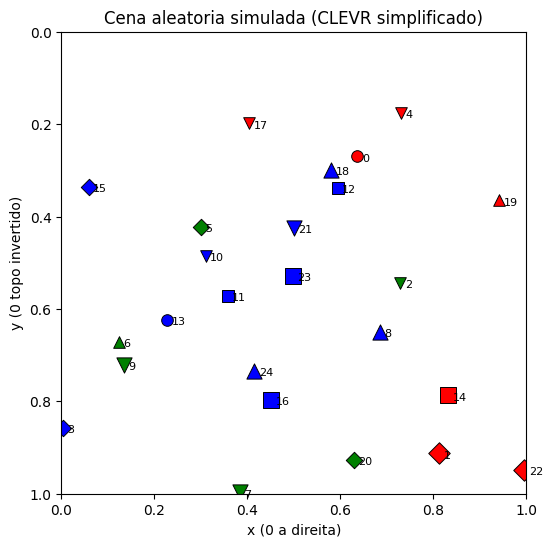

In [5]:
# Geração de dados (uma cena com 25 objetos)

def _sample_object(rng: np.random.Generator):
    pos = rng.random(2)
    color_idx = int(rng.integers(0, len(COLORS)))
    shape_idx = int(rng.integers(0, len(SHAPES)))
    size = float(rng.integers(0, 2))  # 0 pequeno, 1 grande

    feature = np.concatenate(
        [
            pos,
            np.eye(len(COLORS))[color_idx],
            np.eye(len(SHAPES))[shape_idx],
            [size],
        ]
    ).astype(np.float32)

    meta = {
        "pos": pos,
        "color": COLORS[color_idx],
        "shape": SHAPES[shape_idx],
        "size": "grande" if size > 0.5 else "pequeno",
    }
    return feature, meta


def generate_dataset(num_objects=25, seed=0):
    rng = np.random.default_rng(seed)
    feats = []
    meta = []
    for _ in range(num_objects):
        f, m = _sample_object(rng)
        feats.append(f)
        meta.append(m)
    features = torch.tensor(np.stack(feats), device=device)
    return features, meta


def plot_scene(features, meta):
    colors_map = {"vermelho": "red", "verde": "green", "azul": "blue"}
    markers = {
        "circulo": "o",
        "quadrado": "s",
        "cilindro": "D",
        "cone": "^",
        "triangulo": "v",
    }

    plt.figure(figsize=(6, 6))
    for idx, (feat, obj) in enumerate(zip(features.detach().cpu().numpy(), meta)):
        x, y = float(feat[0]), float(feat[1])
        plt.scatter(
            x,
            y,
            c=colors_map[obj["color"]],
            marker=markers[obj["shape"]],
            s=120 if obj["size"] == "grande" else 70,
            edgecolors="k",
            linewidths=0.7,
        )
        plt.text(x + 0.01, y + 0.01, str(idx), fontsize=8)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()
    plt.xlabel("x (0 a direita)")
    plt.ylabel("y (0 topo invertido)")
    plt.title("Cena aleatoria simulada (CLEVR simplificado)")
    plt.show()


# Cena de demonstração
features_demo, meta_demo = generate_dataset(seed=0)
plot_scene(features_demo, meta_demo)


## 3.3 Cena manual (para `sat_manual` e para explicar Q1/Q2)


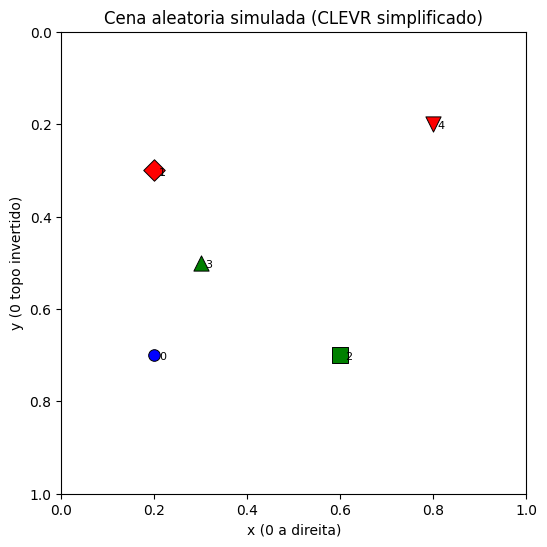

In [6]:
# Cena manual (para sat_manual e checagem das queries Q1/Q2)
# A ideia é criar um cenário "controlado" onde (idealmente):
# - exista um objeto pequeno abaixo de um cilindro e à esquerda de um quadrado (Q1)
# - exista um cone verde entre dois objetos (Q2)

def make_manual_scene():
    # 0: pequeno (x=0.2,y=0.7), azul, circulo
    # 1: grande (x=0.2,y=0.3), vermelho, cilindro   -> acima de 0 (y menor)
    # 2: grande (x=0.6,y=0.7), verde, quadrado       -> à direita de 0
    # 3: grande (x=0.3,y=0.5), verde, cone           -> entre 0 (x=0.2) e 2 (x=0.6)
    # 4: grande (x=0.8,y=0.2), vermelho, triangulo   -> extra

    def one_hot(n, idx):
        v = np.zeros(n, dtype=np.float32)
        v[idx] = 1.0
        return v

    objs = []
    meta = []

    specs = [
        ((0.2, 0.7), "azul", "circulo", 0.0),
        ((0.2, 0.3), "vermelho", "cilindro", 1.0),
        ((0.6, 0.7), "verde", "quadrado", 1.0),
        ((0.3, 0.5), "verde", "cone", 1.0),
        ((0.8, 0.2), "vermelho", "triangulo", 1.0),
    ]

    for (x, y), c, s, size in specs:
        f = np.concatenate(
            [
                np.array([x, y], dtype=np.float32),
                one_hot(len(COLORS), COLORS.index(c)),
                one_hot(len(SHAPES), SHAPES.index(s)),
                np.array([size], dtype=np.float32),
            ]
        )
        objs.append(f)
        meta.append({"pos": (x, y), "color": c, "shape": s, "size": "grande" if size > 0.5 else "pequeno"})

    features = torch.tensor(np.stack(objs), device=device)
    return features, meta


features_manual, meta_manual = make_manual_scene()
plot_scene(features_manual, meta_manual)


In [7]:
# Ground-truth (a partir do próprio vetor) para supervisionar as redes
# Isso deixa o treino bem "científico": a rede aprende a reconhecer atributos/relações
# e simultaneamente precisa satisfazer os axiomas lógicos.

def gt_unary(features):
    # retorna targets em {0,1}
    shapes = features[:, IDX["shapes"]]
    colors = features[:, IDX["colors"]]
    big = (features[:, IDX["size"]] > 0.5).float()
    small = 1.0 - big
    return {"shapes": shapes, "colors": colors, "big": big, "small": small}


def _pairwise_matrix_from_condition(cond_bool):
    return cond_bool.float()


def gt_relations(features, margin=0.02, close_thr=0.18):
    # features: [N,11]
    x = features[:, IDX["pos_x"]].unsqueeze(1)  # [N,1]
    y = features[:, IDX["pos_y"]].unsqueeze(1)  # [N,1]

    xj = x.t()  # [1,N]
    yj = y.t()

    left = _pairwise_matrix_from_condition(x + margin < xj)     # i left of j
    right = _pairwise_matrix_from_condition(x > xj + margin)    # i right of j
    below = _pairwise_matrix_from_condition(y > yj + margin)    # i below j
    above = _pairwise_matrix_from_condition(y + margin < yj)    # i above j

    # closeTo: kernel gaussiano sugerido no enunciado (alvo fuzzy em [0,1])
    dx = x - xj
    dy = y - yj
    dist2 = dx * dx + dy * dy
    close = torch.exp(-2.0 * dist2).clamp(0.0, 1.0)

    # sameSize
    size = (features[:, IDX["size"]] > 0.5).float().unsqueeze(1)
    same_size = _pairwise_matrix_from_condition(size == size.t())

    # canStack (fórmula simplificada, inspirada no enunciado + heurística)
    shapes = features[:, IDX["shapes"]]
    is_cone = shapes[:, SHAPES.index("cone")].unsqueeze(1)
    is_tri = shapes[:, SHAPES.index("triangulo")].unsqueeze(1)
    support_ok = (1.0 - is_cone) * (1.0 - is_tri)  # depende do y (objeto de baixo)

    # estabilidade: centros com x parecido
    stab = torch.exp(-((dx / 0.08) ** 2)).clamp(0.0, 1.0)

    can_stack = ((support_ok.t()) * torch.maximum(same_size, (stab > 0.5).float())).clamp(0.0, 1.0)

    # inBetween (no eixo x): i entre j e k
    xi = features[:, IDX["pos_x"]].view(-1, 1, 1)  # [N,1,1]
    xj = features[:, IDX["pos_x"]].view(1, -1, 1)  # [1,N,1]
    xk = features[:, IDX["pos_x"]].view(1, 1, -1)  # [1,1,N]
    in_between = (((xj + margin < xi) & (xi + margin < xk)) | ((xk + margin < xi) & (xi + margin < xj))).float()

    return {
        "left": left,
        "right": right,
        "below": below,
        "above": above,
        "close": close,
        "same_size": same_size,
        "can_stack": can_stack,
        "in_between": in_between,
    }


## 3.4 Predicados com redes neurais (MLPs treináveis)


In [8]:
# Predicados diferenciáveis (treináveis) via MLPs
# - predicados unários: input 11D
# - binários: concat 22D
# - ternários: concat 33D

class UnaryMLP(nn.Module):
    def __init__(self, in_dim=11, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        if hasattr(x, "value"):
            x = x.value
        out = self.net(x)
        return out.squeeze(-1).clamp(0.0, 1.0)


class BinaryMLP(nn.Module):
    def __init__(self, in_dim=22, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        if hasattr(x, "value"):
            x = x.value
        if hasattr(y, "value"):
            y = y.value
        x, y = torch.broadcast_tensors(x, y)
        xy = torch.cat([x, y], dim=-1)
        out = self.net(xy)
        return out.squeeze(-1).clamp(0.0, 1.0)


class TernaryMLP(nn.Module):
    def __init__(self, in_dim=33, hidden=96):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y, z):
        if hasattr(x, "value"):
            x = x.value
        if hasattr(y, "value"):
            y = y.value
        if hasattr(z, "value"):
            z = z.value
        x, y, z = torch.broadcast_tensors(x, y, z)
        xyz = torch.cat([x, y, z], dim=-1)
        out = self.net(xyz)
        return out.squeeze(-1).clamp(0.0, 1.0)


def make_trainable_predicates(seed=0):
    torch.manual_seed(seed)

    modules = []

    # atributos
    shape_predicates = {}
    for name in SHAPES:
        m = UnaryMLP()
        modules.append(m)
        shape_predicates[name] = ltn.Predicate(m)

    color_predicates = {}
    for name in COLORS:
        m = UnaryMLP()
        modules.append(m)
        color_predicates[name] = ltn.Predicate(m)

    m_small = UnaryMLP()
    m_big = UnaryMLP()
    modules += [m_small, m_big]
    is_small = ltn.Predicate(m_small)
    is_big = ltn.Predicate(m_big)

    # relações
    m_left = BinaryMLP()
    m_right = BinaryMLP()
    m_close = BinaryMLP()
    m_below = BinaryMLP()
    m_above = BinaryMLP()
    m_same = BinaryMLP()
    m_stack = BinaryMLP()
    m_between = TernaryMLP()

    modules += [m_left, m_right, m_close, m_below, m_above, m_same, m_stack, m_between]

    preds = {
        "shape": shape_predicates,
        "color": color_predicates,
        "is_small": ltn.Predicate(m_small),
        "is_big": ltn.Predicate(m_big),
        "left_of": ltn.Predicate(m_left),
        "right_of": ltn.Predicate(m_right),
        "close_to": ltn.Predicate(m_close),
        "below": ltn.Predicate(m_below),
        "above": ltn.Predicate(m_above),
        "same_size": ltn.Predicate(m_same),
        "can_stack": ltn.Predicate(m_stack),
        "in_between": ltn.Predicate(m_between),
        "modules": modules,
    }
    return preds


## 3.5 Axiomas (Tarefas 1, 2 e 3) e Consultas (Tarefa 4)


In [9]:
# Axiomas das tarefas 1-3 + consultas (tarefa 4)

from itertools import combinations

def build_axioms(features, preds):
    x = ltn.Variable("x", features)
    y = ltn.Variable("y", features)
    z = ltn.Variable("z", features)

    shapes = list(preds["shape"].values())

    axioms_t1 = [
        # Cobertura (completude)
        Forall(x, OrN(*[p(x) for p in shapes])),
        # isSmall ou isBig
        Forall(x, Or(preds["is_small"](x), preds["is_big"](x))),
        # não pode ser small e big ao mesmo tempo
        Forall(x, Not(And(preds["is_small"](x), preds["is_big"](x)))),
    ]
    # forma única: não pode ser duas formas ao mesmo tempo
    for p, q in combinations(shapes, 2):
        axioms_t1.append(Forall(x, Not(And(p(x), q(x)))))

    # Tarefa 2: raciocínio horizontal
    axioms_t2 = [
        # irreflexividade
        Forall(x, Not(preds["left_of"](x, x))),
        # assimetria
        Forall(ltn.diag(x, y), Implies(preds["left_of"](x, y), Not(preds["left_of"](y, x)))),
        # inverso (bicondicional): LeftOf(x,y) <-> RightOf(y,x)
        Forall(ltn.diag(x, y), Iff(preds["left_of"](x, y), preds["right_of"](y, x))),
        # transitividade: LeftOf(x,y) & LeftOf(y,z) -> LeftOf(x,z)
        Forall(ltn.diag(x, y, z), Implies(And(preds["left_of"](x, y), preds["left_of"](y, z)), preds["left_of"](x, z))),
        # definição sugerida para InBetween (amarrar ternário com left/right)
        Forall(
            ltn.diag(x, y, z),
            Iff(
                preds["in_between"](x, y, z),
                Or(
                    And(preds["left_of"](y, x), preds["right_of"](z, x)),
                    And(preds["left_of"](z, x), preds["right_of"](y, x)),
                ),
            ),
        ),
        # restrição quadrado-círculo (opcional no PDF, mas útil)
        Forall(ltn.diag(x, y), Implies(And(preds["shape"]["quadrado"](x), preds["shape"]["circulo"](y)), preds["right_of"](x, y))),
    ]

    # Tarefa 3: raciocínio vertical
    axioms_t3 = [
        Forall(x, Not(preds["below"](x, x))),
        # inverso (bicondicional): below(x,y) <-> above(y,x)
        Forall(ltn.diag(x, y), Iff(preds["below"](x, y), preds["above"](y, x))),
        # transitividade
        Forall(ltn.diag(x, y, z), Implies(And(preds["below"](x, y), preds["below"](y, z)), preds["below"](x, z))),
        # canStack -> y não é cone nem triângulo
        Forall(ltn.diag(x, y), Implies(preds["can_stack"](x, y), And(Not(preds["shape"]["cone"](y)), Not(preds["shape"]["triangulo"](y))))),
    ]

    # lastOnTheLeft / lastOnTheRight (existenciais)
    # ∃x (∀y leftOf(x,y))
    last_left = Exists(x, Forall(y, preds["left_of"](x, y)))
    last_right = Exists(x, Forall(y, preds["right_of"](x, y)))

    return {
        "x": x, "y": y, "z": z,
        "t1": axioms_t1,
        "t2": axioms_t2,
        "t3": axioms_t3,
        "last_left": last_left,
        "last_right": last_right,
    }


def evaluate_queries(features, preds):
    x = ltn.Variable("x", features)
    y = ltn.Variable("y", features)
    z = ltn.Variable("z", features)

    # Q1
    query_small_below_cyl_left_square = Exists(
        ltn.diag(x, y, z),
        AndN(
            preds["is_small"](x),
            preds["shape"]["cilindro"](y),
            preds["shape"]["quadrado"](z),
            preds["below"](x, y),
            preds["left_of"](x, z),
        ),
    )

    # Q2
    query_green_cone_between = Exists(
        ltn.diag(x, y, z),
        AndN(
            preds["shape"]["cone"](x),
            preds["color"]["verde"](x),
            preds["in_between"](x, y, z),
        ),
    )

    triangle_proximity_rule = Forall(
        ltn.diag(x, y),
        Implies(
            AndN(preds["shape"]["triangulo"](x), preds["shape"]["triangulo"](y), preds["close_to"](x, y)),
            preds["same_size"](x, y),
        ),
    )

    return {
        "query_small_below_cyl_left_square": query_small_below_cyl_left_square,
        "query_green_cone_between": query_green_cone_between,
        "triangle_proximity_rule": triangle_proximity_rule,
    }


## 3.6 Treinamento da Base de Conhecimento (KB)


In [10]:
# Treino da KB: satisfação dos axiomas + supervisão por ground-truth

def supervised_loss(features, preds, rel_margin=0.02, close_thr=0.18):
    x = ltn.Variable("x_sup", features)
    y = ltn.Variable("y_sup", features)
    z = ltn.Variable("z_sup", features)

    gtU = gt_unary(features)
    gtR = gt_relations(features, margin=rel_margin, close_thr=close_thr)

    losses = []

    # shapes (5)
    for i, name in enumerate(SHAPES):
        p = preds["shape"][name](x).value
        t = gtU["shapes"][:, i]
        losses.append(F.binary_cross_entropy(p, t))

    # colors (3)
    for i, name in enumerate(COLORS):
        p = preds["color"][name](x).value
        t = gtU["colors"][:, i]
        losses.append(F.binary_cross_entropy(p, t))

    # big/small
    losses.append(F.binary_cross_entropy(preds["is_big"](x).value, gtU["big"]))
    losses.append(F.binary_cross_entropy(preds["is_small"](x).value, gtU["small"]))

    # relações pairwise (N,N)
    p_left = preds["left_of"](x, y).value
    p_right = preds["right_of"](x, y).value
    p_below = preds["below"](x, y).value
    p_above = preds["above"](x, y).value
    p_close = preds["close_to"](x, y).value
    p_same = preds["same_size"](x, y).value
    p_stack = preds["can_stack"](x, y).value

    losses.append(F.binary_cross_entropy(p_left, gtR["left"]))
    losses.append(F.binary_cross_entropy(p_right, gtR["right"]))
    losses.append(F.binary_cross_entropy(p_below, gtR["below"]))
    losses.append(F.binary_cross_entropy(p_above, gtR["above"]))
    losses.append(F.binary_cross_entropy(p_close, gtR["close"]))
    losses.append(F.binary_cross_entropy(p_same, gtR["same_size"]))
    losses.append(F.binary_cross_entropy(p_stack, gtR["can_stack"]))

    # ternário (N,N,N)
    p_between = preds["in_between"](x, y, z).value
    losses.append(F.binary_cross_entropy(p_between, gtR["in_between"]))

    return torch.stack(losses).mean()


def train_kb(train_features, preds, epochs=300, lr=1e-3, lambda_kb=1.0, lambda_sup=1.0, verbose=False):
    params = []
    for m in preds["modules"]:
        params += list(m.parameters())

    opt = torch.optim.Adam(params, lr=lr)

    history = []
    for ep in range(1, epochs + 1):
        opt.zero_grad()

        axioms = build_axioms(train_features, preds)
        kb_sat = sat_agg(*axioms["t1"], *axioms["t2"], *axioms["t3"], axioms["last_left"], axioms["last_right"])

        loss_kb = (1.0 - kb_sat)
        loss_sup = supervised_loss(train_features, preds)

        loss = lambda_kb * loss_kb + lambda_sup * loss_sup
        loss.backward()
        opt.step()

        if ep % 50 == 0 or ep == 1 or ep == epochs:
            with torch.no_grad():
                history.append({"epoch": ep, "kb_sat": float(kb_sat.item()), "loss": float(loss.item()), "loss_sup": float(loss_sup.item())})
            if verbose:
                print(f"epoch {ep:4d} | sat={kb_sat.item():.4f} | loss={loss.item():.4f} | sup={loss_sup.item():.4f}")

    return history


# 4. Entregas


## 4.1 Satisfação das fórmulas no conjunto de teste (por fórmula)


In [11]:
# Avaliação: satisfação por fórmula + métricas (acc/prec/recall/F1)

def _binary_metrics(y_true, y_score, thr=0.5):
    # para métricas, convertemos o alvo para binário (>=0.5)
    y_true = (y_true >= 0.5).float()
    y_pred = (y_score >= thr).float()
    tp = (y_pred * y_true).sum().item()
    tn = ((1 - y_pred) * (1 - y_true)).sum().item()
    fp = (y_pred * (1 - y_true)).sum().item()
    fn = ((1 - y_pred) * y_true).sum().item()

    acc = (tp + tn) / max(tp + tn + fp + fn, 1e-9)
    prec = tp / max(tp + fp, 1e-9)
    rec = tp / max(tp + fn, 1e-9)
    f1 = (2 * prec * rec) / max(prec + rec, 1e-9)
    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1}


def classification_metrics(features, preds):
    feats = features.value if hasattr(features, "value") else features
    x = ltn.Variable("x_eval", feats)

    # shape: argmax das 5 saídas
    true_shapes = torch.argmax(feats[:, IDX["shapes"]], dim=1)
    pred_shape_scores = torch.stack([preds["shape"][name](x).value for name in SHAPES], dim=1)
    pred_shapes = torch.argmax(pred_shape_scores, dim=1)
    shape_acc = (pred_shapes == true_shapes).float().mean().item()

    # size
    true_size = torch.round(feats[:, IDX["size"]]).float()
    pred_size = (preds["is_big"](x).value > 0.5).float()
    size_acc = (pred_size == true_size).float().mean().item()

    return {"acc_shape": shape_acc, "acc_size": size_acc}


def relation_metrics(features, preds):
    feats = features.value if hasattr(features, "value") else features
    x = ltn.Variable("x_rel", feats)
    y = ltn.Variable("y_rel", feats)
    z = ltn.Variable("z_rel", feats)

    gtR = gt_relations(feats)

    out = {}

    # pairwise
    out["left"] = _binary_metrics(gtR["left"], preds["left_of"](x, y).value)
    out["right"] = _binary_metrics(gtR["right"], preds["right_of"](x, y).value)
    out["below"] = _binary_metrics(gtR["below"], preds["below"](x, y).value)
    out["above"] = _binary_metrics(gtR["above"], preds["above"](x, y).value)
    out["close"] = _binary_metrics(gtR["close"], preds["close_to"](x, y).value)
    out["same_size"] = _binary_metrics(gtR["same_size"], preds["same_size"](x, y).value)
    out["can_stack"] = _binary_metrics(gtR["can_stack"], preds["can_stack"](x, y).value)

    # ternary
    out["in_between"] = _binary_metrics(gtR["in_between"], preds["in_between"](x, y, z).value)

    return out


def evaluate_all(features, preds):
    axioms = build_axioms(features, preds)
    queries = evaluate_queries(features, preds)

    # satisfação agregada por tarefa
    sat_t1 = float(sat_agg(*axioms["t1"]).item())
    sat_t2 = float(sat_agg(*axioms["t2"]).item())
    sat_t3 = float(sat_agg(*axioms["t3"]).item())
    sat_all = float(sat_agg(*axioms["t1"], *axioms["t2"], *axioms["t3"]).item())

    # satisfação individual por fórmula (nomeada)
    formula_sats = {}
    for i, f in enumerate(axioms["t1"]):
        formula_sats[f"t1_f{i+1:02d}"] = float(f.value.item())
    for i, f in enumerate(axioms["t2"]):
        formula_sats[f"t2_f{i+1:02d}"] = float(f.value.item())
    for i, f in enumerate(axioms["t3"]):
        formula_sats[f"t3_f{i+1:02d}"] = float(f.value.item())

    # last left/right
    formula_sats["lastOnTheLeft"] = float(axioms["last_left"].value.item())
    formula_sats["lastOnTheRight"] = float(axioms["last_right"].value.item())

    query_vals = {k: float(v.value.item()) for k, v in queries.items()}

    # métricas
    cls = classification_metrics(features, preds)
    rel = relation_metrics(features, preds)

    # flatten métricas principais pedidas (inclui left/right/in_between/can_stack)
    flat_rel = {}
    for name, m in rel.items():
        flat_rel[f"acc_{name}"] = m["acc"]
        flat_rel[f"prec_{name}"] = m["precision"]
        flat_rel[f"rec_{name}"] = m["recall"]
        flat_rel[f"f1_{name}"] = m["f1"]

    return {
        "sat_t1": sat_t1,
        "sat_t2": sat_t2,
        "sat_t3": sat_t3,
        "sat_all": sat_all,
        **query_vals,
        **cls,
        **flat_rel,
        "formula_sats": formula_sats,
    }


## 4.2 Execução completa: treino + avaliação (teste e manual)


In [12]:
# Execução de um experimento: treino completo + avaliação em teste e manual

def run_experiment(seed=0, num_objects=25, epochs=300, lr=1e-3, verbose=False):
    # treino e teste (test com seed deslocada)
    train_features, train_meta = generate_dataset(num_objects=num_objects, seed=seed)
    test_features, test_meta = generate_dataset(num_objects=num_objects, seed=seed * 1000 + 999)

    # manual
    manual_features, manual_meta = make_manual_scene()

    preds = make_trainable_predicates(seed=seed)
    # move módulos pro device
    for m in preds["modules"]:
        m.to(device)

    history = train_kb(train_features, preds, epochs=epochs, lr=lr, verbose=verbose)

    test_eval = evaluate_all(test_features, preds)
    manual_eval = evaluate_all(manual_features, preds)

    out = {
        "seed": seed,
        # satisfação agregada
        "sat_test": test_eval["sat_all"],
        "sat_manual": manual_eval["sat_all"],
        # queries no teste
        "q1_test": test_eval["query_small_below_cyl_left_square"],
        "q2_test": test_eval["query_green_cone_between"],
        "q3_test": test_eval["triangle_proximity_rule"],
        # queries no manual (foco em Q1/Q2)
        "q1_manual": manual_eval["query_small_below_cyl_left_square"],
        "q2_manual": manual_eval["query_green_cone_between"],
        "q3_manual": manual_eval["triangle_proximity_rule"],
        # métricas (principais)
        "f1_left": test_eval["f1_left"],
        "f1_right": test_eval["f1_right"],
        "f1_in_between": test_eval["f1_in_between"],
        "f1_can_stack": test_eval["f1_can_stack"],
        # métricas de atributos
        "acc_shape": test_eval["acc_shape"],
        "acc_size": test_eval["acc_size"],
        # para inspeção
        "test_formula_sats": test_eval["formula_sats"],
        "manual_formula_sats": manual_eval["formula_sats"],
        "history": history,
        "preds": preds,
        "test_scene": (test_features, test_meta),
        "manual_scene": (manual_features, manual_meta),
    }
    return out

example = run_experiment(seed=0, epochs=200, lr=1e-3, verbose=False)
pd.DataFrame([{
    "seed": example["seed"],
    "sat_test": example["sat_test"],
    "sat_manual": example["sat_manual"],
    "q1_test": example["q1_test"],
    "q2_test": example["q2_test"],
    "q1_manual": example["q1_manual"],
    "q2_manual": example["q2_manual"],
    "f1_left": example["f1_left"],
    "f1_right": example["f1_right"],
    "f1_in_between": example["f1_in_between"],
    "f1_can_stack": example["f1_can_stack"],
    "acc_shape": example["acc_shape"],
    "acc_size": example["acc_size"],
}])


,seed,sat_test,sat_manual,q1_test,q2_test,q1_manual,q2_manual,f1_left,f1_right,f1_in_between,f1_can_stack,acc_shape,acc_size
0,0,0.858117,0.853299,0.000812,0.00811,0.00045,0.01968,0.469314,0.605965,0.067475,0.631579,1.0,0.88


## 4.3 Repetição por 5 seeds (5 treinos completos)

Repete a geração do dataset + treino + avaliação 5 vezes (seeds 0..4) e mostra **média ± desvio**.


In [13]:
# Repetir para 5 seeds (5 treinos completos) e registrar média ± desvio
results = [run_experiment(seed=s, epochs=300, lr=1e-3, verbose=False) for s in range(5)]

df = pd.DataFrame([{
    "seed": r["seed"],
    "sat_test": r["sat_test"],
    "sat_manual": r["sat_manual"],
    "q1_test": r["q1_test"],
    "q2_test": r["q2_test"],
    "q3_test": r["q3_test"],
    "q1_manual": r["q1_manual"],
    "q2_manual": r["q2_manual"],
    "f1_left": r["f1_left"],
    "f1_right": r["f1_right"],
    "f1_in_between": r["f1_in_between"],
    "f1_can_stack": r["f1_can_stack"],
    "acc_shape": r["acc_shape"],
    "acc_size": r["acc_size"],
} for r in results])

display(df)

def mean_std(series):
    return f"{series.mean():.3f} ± {series.std(ddof=1):.3f}"

summary = pd.DataFrame([{
    "sat_test": mean_std(df["sat_test"]),
    "sat_manual": mean_std(df["sat_manual"]),
    "f1_left": mean_std(df["f1_left"]),
    "f1_right": mean_std(df["f1_right"]),
    "f1_in_between": mean_std(df["f1_in_between"]),
    "f1_can_stack": mean_std(df["f1_can_stack"]),
    "q1_manual": mean_std(df["q1_manual"]),
    "q2_manual": mean_std(df["q2_manual"]),
}])

print("Resumo (média ± desvio):")
display(summary)

# Mostrar sat por fórmula (teste) para a seed 0
seed0 = results[0]
test_formula_sats = pd.Series(seed0["test_formula_sats"]).sort_index()
manual_formula_sats = pd.Series(seed0["manual_formula_sats"]).sort_index()

print("Satisfação por fórmula (teste) - seed 0:")
display(test_formula_sats.to_frame("sat"))

print("Satisfação por fórmula (manual) - seed 0:")
display(manual_formula_sats.to_frame("sat"))



,seed,sat_test,sat_manual,q1_test,q2_test,q3_test,q1_manual,q2_manual,f1_left,f1_right,f1_in_between,f1_can_stack,acc_shape,acc_size
0,0,0.895547,0.903032,0.000188,0.004903,0.975126,0.000133,0.011422,0.601351,0.757164,0.115209,0.680934,1.0,1.00
1,1,0.905032,0.900056,0.000139,0.009904,0.899194,0.000124,0.015184,0.766562,0.744711,0.181818,0.771513,1.0,0.88
2,2,0.911808,0.892430,0.000184,0.006339,0.970430,0.000126,0.013588,0.767204,0.677761,0.230199,0.894845,1.0,1.00
3,3,0.893719,0.911090,0.000162,0.017703,0.912798,0.000124,0.021413,0.793103,0.802343,0.222445,0.827434,1.0,0.96
4,4,0.907949,0.919196,0.000229,0.010279,0.985236,0.000118,0.024501,0.849271,0.790123,0.102938,0.816162,1.0,0.96


Resumo (média ± desvio):


,sat_test,sat_manual,f1_left,f1_right,f1_in_between,f1_can_stack,q1_manual,q2_manual
0,0.903 ± 0.008,0.905 ± 0.010,0.755 ± 0.093,0.754 ± 0.049,0.171 ± 0.059,0.798 ± 0.079,0.000 ± 0.000,0.017 ± 0.006


Satisfação por fórmula (teste) - seed 0:


,sat
lastOnTheLeft,0.490000
lastOnTheRight,0.550805
t1_f01,0.720975
t1_f02,0.929523
t1_f03,0.824547
t1_f04,0.994260
t1_f05,0.990330
t1_f06,0.988236
t1_f07,0.986265
t1_f08,0.986213


Satisfação por fórmula (manual) - seed 0:


,sat
lastOnTheLeft,0.451848
lastOnTheRight,0.511823
t1_f01,0.847330
t1_f02,0.911456
t1_f03,0.838291
t1_f04,0.991454
t1_f05,0.992309
t1_f06,0.993458
t1_f07,0.993587
t1_f08,0.985145


# 5. Extra: explicação das respostas (raciocínio)

Aqui exibimos, para cada pergunta (Q1 e Q2), o *grounding* (x,y,z) que maximiza a consulta e os scores dos literais que compõem a resposta.


In [14]:
def _decode_obj(features, idx):
    f = features[idx].detach().cpu()
    color = COLORS[int(torch.argmax(f[IDX["colors"]]).item())]
    shape = SHAPES[int(torch.argmax(f[IDX["shapes"]]).item())]
    size = "grande" if f[IDX["size"]].item() > 0.5 else "pequeno"
    return {"idx": idx, "x": float(f[IDX["pos_x"]]), "y": float(f[IDX["pos_y"]]), "color": color, "shape": shape, "size": size}


@torch.no_grad()
def explain_q1(features, preds):
    # Existe pequeno x abaixo de cilindro y e à esquerda de quadrado z
    feats = features
    N = feats.shape[0]
    xV = ltn.Variable("x_e", feats)
    yV = ltn.Variable("y_e", feats)
    zV = ltn.Variable("z_e", feats)

    # scores (N,N,N)
    s_small = preds["is_small"](xV).value.view(N, 1, 1)
    s_cyl = preds["shape"]["cilindro"](yV).value.view(1, N, 1)
    s_sq = preds["shape"]["quadrado"](zV).value.view(1, 1, N)
    s_below = preds["below"](xV, yV).value.view(N, N, 1)
    s_left = preds["left_of"](xV, zV).value.view(N, 1, N)

    score = (s_small * s_cyl * s_sq * s_below * s_left)  # produto (AndProd)
    best = torch.argmax(score)
    i = int(best // (N * N))
    j = int((best % (N * N)) // N)
    k = int(best % N)

    info = {
        "x": _decode_obj(feats, i),
        "y": _decode_obj(feats, j),
        "z": _decode_obj(feats, k),
        "scores": {
            "is_small(x)": float(s_small[i, 0, 0].item()),
            "is_cylinder(y)": float(s_cyl[0, j, 0].item()),
            "is_square(z)": float(s_sq[0, 0, k].item()),
            "below(x,y)": float(s_below[i, j, 0].item()),
            "leftOf(x,z)": float(s_left[i, 0, k].item()),
            "AND(all)": float(score[i, j, k].item()),
        },
    }
    return info


@torch.no_grad()
def explain_q2(features, preds):
    # Existe cone verde x entre y e z
    feats = features
    N = feats.shape[0]
    xV = ltn.Variable("x_e2", feats)
    yV = ltn.Variable("y_e2", feats)
    zV = ltn.Variable("z_e2", feats)

    s_cone = preds["shape"]["cone"](xV).value.view(N, 1, 1)
    s_green = preds["color"]["verde"](xV).value.view(N, 1, 1)
    s_between = preds["in_between"](xV, yV, zV).value  # (N,N,N)

    score = (s_cone * s_green * s_between)
    best = torch.argmax(score)
    i = int(best // (N * N))
    j = int((best % (N * N)) // N)
    k = int(best % N)

    info = {
        "x": _decode_obj(feats, i),
        "y": _decode_obj(feats, j),
        "z": _decode_obj(feats, k),
        "scores": {
            "is_cone(x)": float(s_cone[i, 0, 0].item()),
            "is_green(x)": float(s_green[i, 0, 0].item()),
            "inBetween(x,y,z)": float(s_between[i, j, k].item()),
            "AND(all)": float(score[i, j, k].item()),
        },
    }
    return info


In [15]:
# Explicações (seed 0, cena manual)
preds0 = seed0["preds"]
manual_feats, manual_meta = seed0["manual_scene"]

exp1 = explain_q1(manual_feats, preds0)
exp2 = explain_q2(manual_feats, preds0)

import pandas as pd
from IPython.display import display, Markdown

def _fmt_obj(o):
    return (f"objeto #{o['idx']} ({o['shape']}, {o['color']}, {o['size']}) "
            f"na posição (x={o['x']:.2f}, y={o['y']:.2f})")

def _scores_df(scores: dict):
    df = pd.DataFrame([{"termo": k, "score": float(v)} for k, v in scores.items()])
    return df.sort_values("score", ascending=False).reset_index(drop=True)

def _bottleneck(scores: dict, ignore=("AND(all)",)):
    items = [(k, float(v)) for k, v in scores.items() if k not in ignore]
    return min(items, key=lambda kv: kv[1]) if items else (None, None)

def pretty_explain_exists_query(title: str, exp: dict, template_lines: list[str]):
    display(Markdown(f"### {title}"))

    # 1) Objetos escolhidos
    objs = []
    for var in ["x", "y", "z"]:
        if var in exp and isinstance(exp[var], dict):
            o = exp[var]
            objs.append({
                "var": var,
                "idx": o.get("idx"),
                "x": o.get("x"),
                "y": o.get("y"),
                "color": o.get("color"),
                "shape": o.get("shape"),
                "size": o.get("size"),
            })
    if objs:
        display(Markdown("**Objetos escolhidos (melhor grounding do Exists):**"))
        display(pd.DataFrame(objs))

    # 2) Scores
    scores = exp.get("scores", {})
    if isinstance(scores, dict) and scores:
        display(Markdown("**Scores dos literais:**"))
        df_scores = _scores_df(scores)
        display(df_scores)

        b_name, b_val = _bottleneck(scores)
        and_val = float(scores.get("AND(all)", float("nan")))

        # 3) Linguagem natural
        display(Markdown("**Explicação em linguagem natural:**"))
        x = exp.get("x"); y = exp.get("y"); z = exp.get("z")

        lines = []
        if x: lines.append(f"- Escolhemos **x** como {_fmt_obj(x)}.")
        if y: lines.append(f"- Escolhemos **y** como {_fmt_obj(y)}.")
        if z: lines.append(f"- Escolhemos **z** como {_fmt_obj(z)}.")

        # Frases específicas (você passa pelo template)
        for s in template_lines:
            # substituições simples {chave}
            try:
                lines.append("- " + s.format(**{k: float(v) for k, v in scores.items()}))
            except Exception:
                lines.append("- " + s)

        if b_name is not None:
            lines.append(f"- O fator que mais derrubou a consulta foi **{b_name} = {b_val:.3f}**.")
        lines.append(f"- Como usamos AND por produto, o resultado final foi **AND(all) = {and_val:.6f}** "
                     f"(e o Exists retorna o melhor trio).")

        display(Markdown("\n".join(lines)))

pretty_explain_exists_query(
    "Explicação Q1 (manual) – Existe x pequeno abaixo de y cilindro e à esquerda de z quadrado",
    exp1,
    template_lines=[
        "x é pequeno com grau **{is_small(x):.3f}**.",
        "y é cilindro com grau **{is_cylinder(y):.3f}**.",
        "z é quadrado com grau **{is_square(z):.3f}**.",
        "x está abaixo de y com grau **{below(x,y):.3f}**.",
        "x está à esquerda de z com grau **{leftOf(x,z):.3f}**.",
    ]
)

pretty_explain_exists_query(
    "Explicação Q2 (manual) – Existe x cone verde entre y e z",
    exp2,
    template_lines=[
        "x é cone com grau **{is_cone(x):.3f}**.",
        "x é verde com grau **{is_green(x):.3f}**.",
        "x está entre y e z com grau **{inBetween(x,y,z):.3f}**.",
    ]
)





### Explicação Q1 (manual) – Existe x pequeno abaixo de y cilindro e à esquerda de z quadrado

**Objetos escolhidos (melhor grounding do Exists):**

,var,idx,x,y,color,shape,size
0,x,0,0.2,0.7,azul,circulo,pequeno
1,y,1,0.2,0.3,vermelho,cilindro,grande
2,z,2,0.6,0.7,verde,quadrado,grande


**Scores dos literais:**

,termo,score
0,is_small(x),0.988422
1,"leftOf(x,z)",0.962636
2,is_cylinder(y),0.941370
3,is_square(z),0.678696
4,"below(x,y)",0.247703
5,AND(all),0.150582


**Explicação em linguagem natural:**

- Escolhemos **x** como objeto #0 (circulo, azul, pequeno) na posição (x=0.20, y=0.70).
- Escolhemos **y** como objeto #1 (cilindro, vermelho, grande) na posição (x=0.20, y=0.30).
- Escolhemos **z** como objeto #2 (quadrado, verde, grande) na posição (x=0.60, y=0.70).
- x é pequeno com grau **0.988**.
- y é cilindro com grau **0.941**.
- z é quadrado com grau **0.679**.
- x está abaixo de y com grau **0.248**.
- x está à esquerda de z com grau **0.963**.
- O fator que mais derrubou a consulta foi **below(x,y) = 0.248**.
- Como usamos AND por produto, o resultado final foi **AND(all) = 0.150582** (e o Exists retorna o melhor trio).

### Explicação Q2 (manual) – Existe x cone verde entre y e z

**Objetos escolhidos (melhor grounding do Exists):**

,var,idx,x,y,color,shape,size
0,x,3,0.3,0.5,verde,cone,grande
1,y,0,0.2,0.7,azul,circulo,pequeno
2,z,1,0.2,0.3,vermelho,cilindro,grande


**Scores dos literais:**

,termo,score
0,is_cone(x),0.952266
1,is_green(x),0.903814
2,"inBetween(x,y,z)",0.656955
3,AND(all),0.565423


**Explicação em linguagem natural:**

- Escolhemos **x** como objeto #3 (cone, verde, grande) na posição (x=0.30, y=0.50).
- Escolhemos **y** como objeto #0 (circulo, azul, pequeno) na posição (x=0.20, y=0.70).
- Escolhemos **z** como objeto #1 (cilindro, vermelho, grande) na posição (x=0.20, y=0.30).
- x é cone com grau **0.952**.
- x é verde com grau **0.904**.
- x está entre y e z com grau **0.657**.
- O fator que mais derrubou a consulta foi **inBetween(x,y,z) = 0.657**.
- Como usamos AND por produto, o resultado final foi **AND(all) = 0.565423** (e o Exists retorna o melhor trio).